In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Extracting Image Features

In [4]:
from keras.applications import VGG16
from keras.models import Model

# Instantiate the VGG16 model without downloading weights
model = VGG16(weights=None)

# Load the downloaded weights manually
model.load_weights('/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

# Modify the model to use the second-to-last layer's output
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Print model summary
print(model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [8]:
# Define a dictionary to store image features
features = {}

# Specify the directory containing the images
directory = os.path.join(BASE_DIR, 'Images')

# Iterate through each image in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for VGG
    image = preprocess_input(image)

    # Extract features using the pre-trained model
    feature = model.predict(image, verbose=0)

    # Get image ID from the filename
    image_id = img_name.split('.')[0]

    # Store extracted features in the dictionary
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
# Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


## Loading Captions Data

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [12]:
# Create an empty dictionary to store the mapping of image IDs to captions
mapping = {}

# Iterate through each line in the 'captions_doc'
for line in tqdm(captions_doc.split('\n')): 
    # Split the line by comma(,)
    tokens = line.split(',')
    
    # Check if the line has enough elements (at least 2)
    if len(line) < 2:
        continue
    # Extract the image ID and caption from the tokens    
    image_id, caption = tokens[0], tokens[1:]
    
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    
    # Convert the caption list to a string by joining its elements
    caption = " ".join(caption)
    
    # Create a list if the image ID is not already in the mapping dictionary
    if image_id not in mapping:
        mapping[image_id] = []
    
    # Store the caption in the list associated with the image ID
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
len(mapping)

8091

## Text Preprocessing

In [14]:
def clean(mapping):
    
    # Iterate through each key-value pair in the 'mapping' dictionary
    for key, captions in mapping.items():
        
        # Iterate through each caption associated with the current key
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
        
            # Preprocessing steps for the caption:

            # Convert the caption to lowercase
            caption = caption.lower()
            
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# preprocess the text
clean(mapping)

# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
print(len(all_captions))
print()
print(all_captions[:10])

40455

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [19]:
# Create a tokenizer object to handle text tokenization
tokenizer = Tokenizer()

# Fit the tokenizer on the provided text data (all_captions)
# This process:
#   - Analyzes the text to identify unique words (vocabulary)
#   - Assigns a unique integer ID to each word
tokenizer.fit_on_texts(all_captions)

# Calculate the vocabulary size (number of unique words) plus 1
# The extra 1 accounts for the 0-th index, which is often reserved for padding
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

8485

In [21]:
# Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    
    # Initialize empty lists to store data
    X1, X2, y = list(), list(), list()
    
    n = 0 # Counter for tracking batch size
    
    while 1: # Infinite Loop to yield batches
        
        for key in data_keys: # Iterate through each image key
            n += 1
            
            captions = mapping[key]  # Retrieve captions associated with the image
            
            # process each caption
            for caption in captions:
               
            # Tokenize the caption into a sequence of integer IDs
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # Split the sequence into multiple X, y pairs for training
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # One-Hot Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            # If a batch is complete, yield it and reset        
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y) # Convert to NumPy arrays
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()  # Reset lists for the next batch
                n = 0  # Reset counter

## Modelling

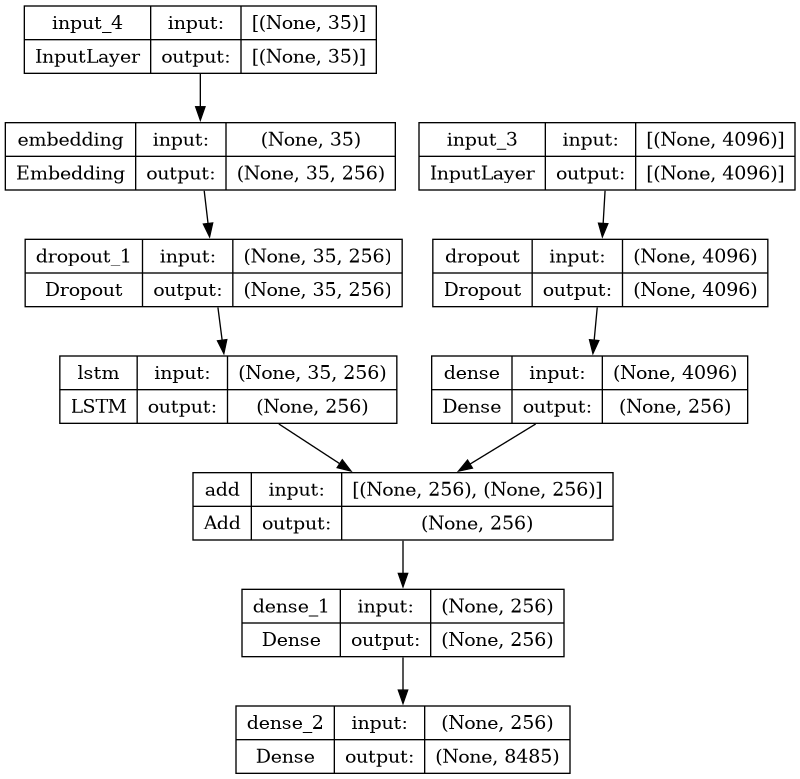

In [25]:
# Encoder Layers:-

# Image feature layers:
inputs1 = Input(shape=(4096,)) # Input for image features (4096 dimensions)
fe1 = Dropout(0.2)(inputs1) # Apply dropout for regularization
fe2 = Dense(256, activation='elu')(fe1) # Dense layer with ReLU activation

# Sequence feature layers:
inputs2 = Input(shape=(max_length,)) # Input for text sequences
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) # Word embedding layer
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2) # LSTM layer to model sequential information

# Decoder layers:-
decoder1 = add([fe2, se3]) # Combine image and sequence features
decoder2 = Dense(256, activation='elu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) # Output layer with softmax for word probabilities

model = Model(inputs=[inputs1, inputs2], outputs=outputs) # Define model with two inputs and one output
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [27]:
# train the model
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 42s 186ms/step - loss: 2.8830


In [28]:
# Save the model using the native Keras format
model.save('img_caption_model.keras')


In [29]:
# Save the model in native Keras format
model.save(WORKING_DIR + '/img_caption_model')


## Generate Captions for Image

In [30]:
def idx_to_word(integer, tokenizer):
    """
    Converts a numerical token ID back to its corresponding word using a tokenizer.

    Args:
        integer: The integer ID representing the word.
        tokenizer: The tokenizer object that was used to tokenize the text.

    Returns:
        The word corresponding to the integer ID, or None if the ID is not found.
    """

    # Iterate through the tokenizer's vocabulary
    for word, index in tokenizer.word_index.items():
        # If the integer ID matches the index of a word, return the word
        if index == integer:
            return word

    # If no matching word is found, return None
    return None

In [31]:
def predict_caption(model, image, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        model: The trained image captioning model.
        image: The image to generate a caption for.
        tokenizer: The tokenizer used to convert text to numerical sequences.
        max_length: The maximum length of the generated caption.

    Returns:
        The generated caption as a string.
    """
    # Add start tag for generation process
    in_text = 'startseq'
    
    # Iterate over the max length of sequence
    for i in range(max_length):
        # Tokenize the current caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # Pad the sequence to match the expected input shape
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        
        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)
        
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # Stop if word not found
        if word is None:
            break
        
        # Append word as input for generating next word
        in_text += " " + word
        
        # Stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text


In [32]:
#VGG16
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.529477
BLEU-2: 0.307712


In [69]:
#RESNET50
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

# Load ResNet50 model pretrained on ImageNet without the top layer
resnet_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Load the downloaded weights manually
resnet_model.load_weights('/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Modify the model to use the second-to-last layer's output
resnet_model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)

# Print model summary
print(resnet_model.summary())

# Define a dictionary to store image features
features = {}

# Specify the directory containing the images
directory = os.path.join(BASE_DIR, 'Images')

# Iterate through each image in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for ResNet50
    image = resnet_preprocess_input(image)

    # Extract features using the pre-trained model
    feature = resnet_model.predict(image, verbose=0)

    # Get image ID from the filename
    image_id = img_name.split('.')[0]

    # Store extracted features in the dictionary
    features[image_id] = feature

# Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))



Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_47 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_47[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

  0%|          | 0/8091 [00:00<?, ?it/s]

In [82]:
# Import necessary libraries
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16, resnet, inception_v3, densenet
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.resnet import preprocess_input as resnet_preprocess_input
from keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from keras.applications.densenet import preprocess_input as densenet_preprocess_input

# Load an image from the provided path
def load_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define paths to the models' weights
alexnet_weights_path = "/kaggle/input/all-weights/alexnet_weights.h5"  # Adjust this path accordingly
vgg16_weights_path = "/kaggle/input/all-weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5"  # Adjust this path accordingly
googlenet_weights_path = "/kaggle/input/all-weights/googlenet_weights.h5"  # Adjust this path accordingly
resnet_weights_path = "/kaggle/input/all-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"  # Adjust this path accordingly

# Load the models with their respective weights
alexnet_model = alexnet(weights=alexnet_weights_path)
vgg16_model = vgg16.VGG16(weights=vgg16_weights_path)
googlenet_model = inception_v3.InceptionV3(weights=googlenet_weights_path)
resnet_model = resnet.ResNet50(weights=resnet_weights_path)

# Preprocess input images based on the model requirements
def preprocess_input(model_name, img_array):
    if model_name == 'alexnet':
        return img_array  # No specific preprocessing for AlexNet
    elif model_name == 'vgg16':
        return vgg16_preprocess_input(img_array)
    elif model_name == 'googlenet':
        return inception_preprocess_input(img_array)
    elif model_name == 'resnet':
        return resnet_preprocess_input(img_array)
    else:
        raise ValueError("Invalid model name provided.")

# Load and preprocess the image
image_path = "/path/to/your/image.jpg"  # Adjust this path accordingly
image_size = (224, 224)  # Rescale images to this size for consistency
image = load_image(image_path, image_size)

# Generate predictions for each model
alexnet_pred = alexnet_model.predict(preprocess_input('alexnet', image))
vgg16_pred = vgg16_model.predict(preprocess_input('vgg16', image))
googlenet_pred = googlenet_model.predict(preprocess_input('googlenet', image))
resnet_pred = resnet_model.predict(preprocess_input('resnet', image))

# Display the predictions
print("AlexNet prediction:", alexnet_pred)
print("VGG16 prediction:", vgg16_pred)
print("GoogLeNet prediction:", googlenet_pred)
print("ResNet prediction:", resnet_pred)


NameError: name 'alexnet' is not defined

In [81]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

# Define AlexNet architecture
def create_alexnet():
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))  # Adjust output units based on your requirements
    return model

# Load and preprocess the image
image_path = "/path/to/your/image.jpg"  # Adjust this path accordingly
image_size = (224, 224)  # Rescale images to this size for consistency
image = load_image(image_path, image_size)

# Create and load AlexNet model with weights
alexnet_model = create_alexnet()
alexnet_weights_path = "/kaggle/input/all-weights/alexnet_weights.h5"  # Adjust this path accordingly
alexnet_model.load_weights(alexnet_weights_path)

# Generate predictions for each model
alexnet_pred = alexnet_model.predict(preprocess_input('alexnet', image))
vgg16_pred = vgg16_model.predict(preprocess_input('vgg16', image))
googlenet_pred = googlenet_model.predict(preprocess_input('googlenet', image))
resnet_pred = resnet_model.predict(preprocess_input('resnet', image))

# Display the predictions
print("AlexNet prediction:", alexnet_pred)
print("VGG16 prediction:", vgg16_pred)
print("GoogLeNet prediction:", googlenet_pred)
print("ResNet prediction:", resnet_pred)


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/image.jpg'

## Testing Model

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy smiles underwater endseq
startseq red-headed boy swimming underwater endseq
startseq small boy swimming underwater endseq
startseq smiling boy swims underwater in pool endseq
startseq the boys smiles underwater at the pool endseq
--------------------Predicted--------------------
startseq child underwater underwater underwater endseq


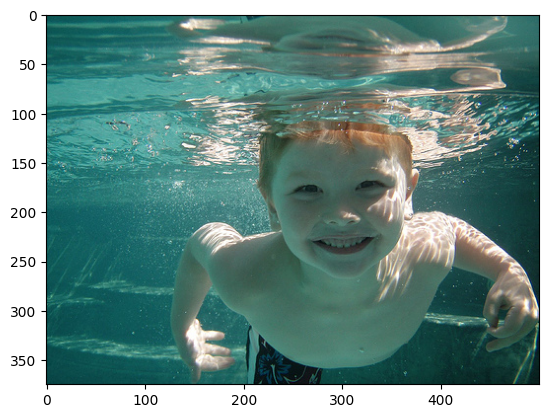

In [34]:
generate_caption("1096165011_cc5eb16aa6.jpg")

---------------------Actual---------------------
startseq people on atvs and dirt bikes are traveling along worn path in field surrounded by trees endseq
startseq three people are riding around on atv 's and motorcycles endseq
startseq three people on motorbikes follow trail through dry grass endseq
startseq three people on two dirt-bikes and one four-wheeler are riding through brown grass endseq
startseq three people ride off-road bikes through field surrounded by trees endseq
--------------------Predicted--------------------
startseq two people are running on dirt road endseq


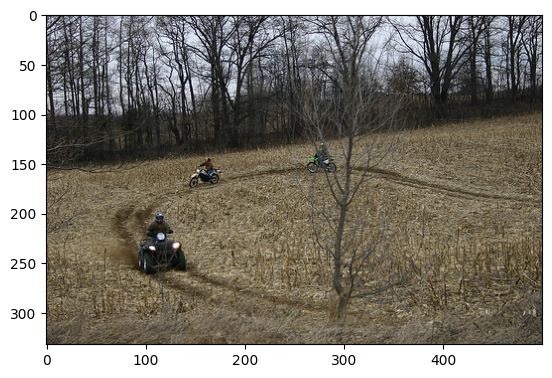

In [35]:
generate_caption("112243673_fd68255217.jpg")

---------------------Actual---------------------
startseq little boy stands in the surf endseq
startseq small child wades through the water while being guided by another person endseq
startseq young boy laughs while splashing in the ocean endseq
startseq young boy wearing colorful bathing suit splashing in the ocean endseq
startseq young child splashing in water endseq
--------------------Predicted--------------------
startseq little boy in pink bathing suit is standing in the water endseq


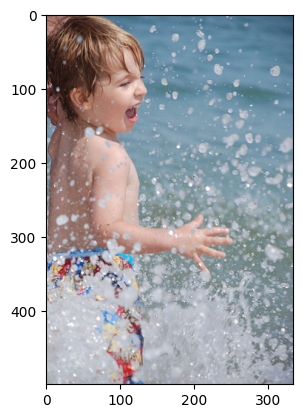

In [36]:
generate_caption("1118557877_736f339752.jpg")

---------------------Actual---------------------
startseq two constructions workers sit on beam taking break endseq
startseq two construction workers are sitting up on the side of building endseq
startseq two construction workers sitting on an i-beam endseq
startseq two construction workers take seat on steel beam endseq
startseq two men take break from construction endseq
--------------------Predicted--------------------
startseq two constructions workers are sitting on blue beam endseq


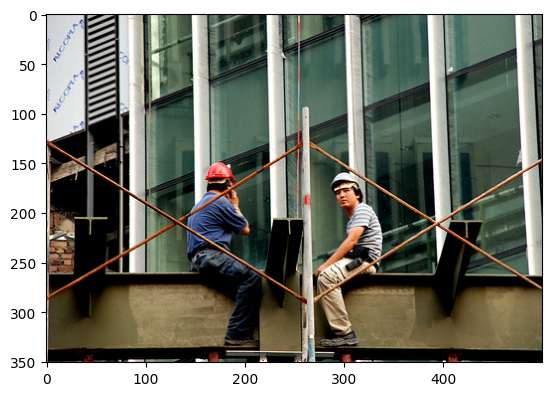

In [37]:
generate_caption("1055753357_4fa3d8d693.jpg")

## Testing with New Images

In [38]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def new_caption(image_path, model, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        image_path (str): Path to the image file.
        model: The trained image captioning model.
        tokenizer: The tokenizer used to encode text for the model.
        max_length: The maximum length of the generated caption.

    Returns:
        str: The generated caption.
    """

    # Load VGG16 model and restructure it to output features from the second-to-last layer
    vgg_model = VGG16()
    vgg_model = keras.models.Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

    # Display the image
    img = load_img(image_path)
    plt.imshow(img)

    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features from the image using VGG16
    feature = vgg_model.predict(image, verbose=0)

    # Generate caption using the trained model
    caption = predict_caption(model, feature, tokenizer, max_length)

    return caption


In [39]:
from PIL import Image
import numpy as np
import tensorflow as tf

def load_and_preprocess_image(image_path):
    # Load image using PIL
    img = Image.open(image_path)
    # Preprocess image using TensorFlow
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.image.resize(img, (224, 224))  # Assuming you want to resize to (224, 224)
    img = tf.keras.applications.resnet50.preprocess_input(img)  # Assuming you're using ResNet50 preprocess_input
    return img


In [43]:
# Load the image
image_path = "/kaggle/input/image-caption-test-v2-0"
image = load_and_preprocess_image(image_path)

# Preprocess the image to match the input shape expected by the model
# (Assuming model input shape is (batch_size, height, width, channels))
image = np.expand_dims(image, axis=0)  # Add batch dimension




IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/image-caption-test-v2-0'

In [41]:
# Assuming you have a function called generate_caption()
caption = generate_caption("/kaggle/input/image-caption-test-v2-0/children_playing.jpg", model, tokenizer, max_length)

# Print the generated caption
print(caption)


TypeError: generate_caption() takes 1 positional argument but 4 were given

In [42]:
new_caption("/kaggle/input/image-caption-test-v2-0/children_playing.jpg",model,tokenizer,max_length)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
new_caption("/kaggle/input/image-caption-test-v2-0/cafe.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/kaggle/input/image-caption-test-v2-0/dog-playtime-927x388.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/kaggle/input/image-caption-test-v2-0/dirt bike.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/kaggle/input/image-caption-test-v2-0/kid_smiling.jpg",model,tokenizer,max_length)

In [ ]:
# Save the tokenizer for future use
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer, f)


In [ ]:
# Load the trained models with actual file paths
encoder_model = load_model('/kaggle/input/autoencoders-extracting-relevant-features/encoder_model.h5')
decoder_model = load_model('/kaggle/input/autoencoders-extracting-relevant-features/decoder_model.h5')


Story generation

In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import json
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models

# Load the captions from your dataset
# Provide the correct path to your captions file
df = pd.read_csv('/kaggle/input/flickr8k/captions.txt', delimiter=',')

# Extract captions from the DataFrame
captions = df['caption'].tolist()

# Tokenize captions
all_words = ' '.join(captions).split()
word_counts = Counter(all_words)

# Sort words by frequency and select the most common ones
vocab_size = 10000  # Adjust as needed
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab = ['<unk>', '<start>', '<end>'] + vocab[:vocab_size - 3]  # Add special tokens and limit vocabulary size
tokenizer = {word: idx for idx, word in enumerate(vocab)}

# Save the tokenizer for future use
with open('/kaggle/working/tokenizer.json', 'w') as f:
    json.dump(tokenizer, f)

# Load the VGG16 model pretrained on ImageNet without the top layer
vgg_model = tf.keras.applications.VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
vgg_model.load_weights('/kaggle/input/vgg16-weights-now/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Define LSTM model for caption generation
embedding_dim = 256  # Adjust as needed
units = 512  # Adjust as needed

# Image feature extractor model
image_input = layers.Input(shape=(224, 224, 3))
image_features = vgg_model(image_input)
image_features = layers.Flatten()(image_features)
image_features = layers.Dense(units, activation='relu')(image_features)  # Map to desired size

# Caption generator model
caption_input = layers.Input(shape=(None,))
caption_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(caption_input)
lstm = layers.LSTM(units, return_sequences=True, return_state=True)
lstm_output, _, _ = lstm(caption_embedding, initial_state=[image_features, image_features])
output = layers.Dense(vocab_size, activation='softmax')(lstm_output)

model = models.Model(inputs=[image_input, caption_input], outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# Train the model using your dataset (image features and captions)

# Define preprocess_image function
def preprocess_image(img_path):
    # Read and resize the image
    img = load_img(img_path, target_size=(224, 224))
    # Convert to numpy array
    img_array = img_to_array(img)
    # Expand dimensions to match input shape of VGG model
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the input image
    img_array = preprocess_input(img_array)
    return img_array

# Define generate_caption function
def generate_caption(image_path, max_length=50):
    img = preprocess_image(image_path)
    initial_state = [np.zeros((1, units)), np.zeros((1, units))]
    caption = ['<start>']
    for i in range(max_length):
        seq = [tokenizer.get(word, tokenizer['<unk>']) for word in caption]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')
        predictions = model.predict([img, seq])
        predicted_word_index = np.argmax(predictions[0, i, :])
        predicted_word = [word for word, idx in tokenizer.items() if idx == predicted_word_index][0]
        if predicted_word == '<end>':
            break
        caption.append(predicted_word)
    return ' '.join(caption[1:])  # Exclude the start token

# Define generate_story function (optional)
def generate_story(image_path, num_sentences=3):
    captions = [generate_caption(image_path) for _ in range(num_sentences)]
    story = ' '.join(captions)
    return story

# Example usage
image_path = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
generated_caption = generate_caption(image_path)
print("Generated Caption:", generated_caption)

generated_story = generate_story(image_path)
print("Generated Story:")
print(generated_story)



1/1 [==============================] - 0s 34ms/step
Generated Caption: sheepdogs doorstep doorstep doorstep doorstep sheepdogs sheepdogs sheepdogs sheepdogs bares bares bares bares sideline sideline driver driver driver driver driver driver driver barking driver driver Boys Boys Boys adults tipped woman gith aided unoccupied bunch intensely tv march Trumpet Girls Girls brides 08 lifevests playtoy appearing lightly lightly inspects step
1/1 [==============================] - 0s 33ms/step
Generated Story:
sheepdogs doorstep doorstep doorstep doorstep sheepdogs sheepdogs sheepdogs sheepdogs bares bares bares bares sideline sideline driver driver driver driver driver driver driver barking driver driver Boys Boys Boys adults tipped woman gith aided unoccupied bunch intensely tv march Trumpet Girls Girls brides 08 lifevests playtoy appearing lightly lightly inspects step sheepdogs doorstep doorstep doorstep doorstep sheepdogs sheepdogs sheepdogs sheepdogs bares bares bares bares sideline sid

In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import json
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models

# Load the captions from your dataset
# Provide the correct path to your captions file
df = pd.read_csv('/kaggle/input/flickr8k/captions.txt', delimiter=',')

# Extract captions from the DataFrame
captions = df['caption'].tolist()

# Tokenize captions
all_words = ' '.join(captions).split()
word_counts = Counter(all_words)

# Sort words by frequency and select the most common ones
vocab_size = 10000  # Adjust as needed
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab = ['<unk>', '<start>', '<end>'] + vocab[:vocab_size - 3]  # Add special tokens and limit vocabulary size
tokenizer = {word: idx for idx, word in enumerate(vocab)}

# Save the tokenizer for future use
with open('/kaggle/working/tokenizer.json', 'w') as f:
    json.dump(tokenizer, f)

# Load the VGG16 model pretrained on ImageNet without the top layer
vgg_model = tf.keras.applications.VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
vgg_model.load_weights('/kaggle/input/vgg16-weights-now/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Define LSTM model for caption generation
embedding_dim = 256  # Adjust as needed
units = 512  # Adjust as needed

# Image feature extractor model
image_input = layers.Input(shape=(224, 224, 3))
image_features = vgg_model(image_input)
image_features = layers.Flatten()(image_features)
image_features = layers.Dense(units, activation='relu')(image_features)  # Map to desired size

# Caption generator model
caption_input = layers.Input(shape=(None,))
caption_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(caption_input)
lstm = layers.LSTM(units, return_sequences=True, return_state=True)
lstm_output, _, _ = lstm(caption_embedding, initial_state=[image_features, image_features])
output = layers.Dense(vocab_size, activation='softmax')(lstm_output)

model = models.Model(inputs=[image_input, caption_input], outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# Train the model using your dataset (image features and captions)

# Define preprocess_image function
def preprocess_image(img_path):
    # Read and resize the image
    img = load_img(img_path, target_size=(224, 224))
    # Convert to numpy array
    img_array = img_to_array(img)
    # Expand dimensions to match input shape of VGG model
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the input image
    img_array = preprocess_input(img_array)
    return img_array

# Define generate_caption function
def generate_caption(image_path, max_length=50):
    img = preprocess_image(image_path)
    initial_state = [np.zeros((1, units)), np.zeros((1, units))]
    caption = ['<start>']
    for i in range(max_length):
        seq = [tokenizer.get(word, tokenizer['<unk>']) for word in caption]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')
        predictions = model.predict([img, seq])
        predicted_word_index = np.argmax(predictions[0, i, :])
        predicted_word = [word for word, idx in tokenizer.items() if idx == predicted_word_index][0]
        if predicted_word == '<end>':
            break
        caption.append(predicted_word)
    return ' '.join(caption[1:])  # Exclude the start token

# Define generate_story function (optional)
def generate_story(image_path, num_sentences=3):
    captions = [generate_caption(image_path) for _ in range(num_sentences)]
    story = ' '.join(captions)
    return story

# Example usage
image_path = '/kaggle/input/flickr8k/Images/102351840_323e3de834.jpg'
generated_caption = generate_caption(image_path)
print("Generated Caption:", generated_caption)

generated_story = generate_story(image_path)
print("Generated Story:")
print(generated_story)


1/1 [==============================] - 0s 33ms/step
Generated Caption: shredded railling railling railling railling railling lifesavers lifesavers lifesavers lifesavers lifesavers lifesavers lifesavers lifesavers hold hold hold hold hold snuggles snuggles snuggles snuggles snuggles snuggles snuggles snuggles snuggles Tennis juming clowds Tennis rock-climber <unk> jazz guardsman clowds An An colorful fend control control striped flanked walkway walkway 08 ejected haircut
1/1 [==============================] - 0s 33ms/step
Generated Story:
shredded railling railling railling railling railling lifesavers lifesavers lifesavers lifesavers lifesavers lifesavers lifesavers lifesavers hold hold hold hold hold snuggles snuggles snuggles snuggles snuggles snuggles snuggles snuggles snuggles Tennis juming clowds Tennis rock-climber <unk> jazz guardsman clowds An An colorful fend control control striped flanked walkway walkway 08 ejected haircut shredded railling railling railling railling raillin

## The model is generating decent captions. Although it is not highly accurate, but still it is able to capture details of the image and is generating text related to it. If we feed our model with more data, our caption will be more accurate (You can use Flickr30k dataset,or try out with other pretrained models like => ResNet, Inception, Xception)